In [31]:
from scraping import scraper
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [37]:
years = np.arange(2000, 2023)
scraper = scraper(years = [2022])
_ = scraper.fit()

games = pd.read_csv('data_1980_2022.csv')
games.head()

,Date,Season,Game_home,Game_away,Home,Away,Result,G_home,G_away,PTS%,...,GA_inf,GD_1,GD_2,GD_5,GD_10,GD_inf,Rest,Draw,Loss,Win
0,1979-08-18,1980,1,1,Bristol City,Leeds United,0,2,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,1979-08-18,1980,1,1,Tottenham,Middlesbrough,-1,1,3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,1979-08-18,1980,1,1,Southampton,Manchester Utd,0,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,1979-08-18,1980,1,1,West Brom,Derby County,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,1979-08-18,1980,1,1,Bolton,Aston Villa,0,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


In [47]:
# Load historical match data
data = games.copy()[(games['Game_home'] >= 5) & (games['Game_away'] >= 5) & (games['Rest'].abs() < 40)]
#train, test = train_test_split(data, test_size = 0.1)
train = data.copy()[data['Season'] <  2022]
test  = data.copy()[data['Season'] == 2022]
X_train, X_test = np.array(train[scraper.features]), np.array(test[scraper.features])
y_train, y_test = np.array(train[['Win', 'Draw', 'Loss']]), np.array(test[['Win', 'Draw', 'Loss']])

# Create neural network model
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = len(scraper.features)))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(3,  activation = 'softmax'))

# Compile model
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.1)

Epoch 1/50
428/428 [==============================] - 1s 762us/step - loss: 1.0471 - accuracy: 0.4660 - val_loss: 1.0059 - val_accuracy: 0.5141
Epoch 2/50
428/428 [==============================] - 0s 579us/step - loss: 1.0229 - accuracy: 0.4935 - val_loss: 1.0000 - val_accuracy: 0.5148
Epoch 3/50
428/428 [==============================] - 0s 598us/step - loss: 1.0192 - accuracy: 0.4962 - val_loss: 0.9918 - val_accuracy: 0.5201
Epoch 4/50
428/428 [==============================] - 0s 626us/step - loss: 1.0173 - accuracy: 0.4964 - val_loss: 0.9959 - val_accuracy: 0.5227
Epoch 5/50
428/428 [==============================] - 0s 598us/step - loss: 1.0172 - accuracy: 0.4963 - val_loss: 0.9931 - val_accuracy: 0.5227
Epoch 6/50
428/428 [==============================] - 0s 606us/step - loss: 1.0145 - accuracy: 0.4978 - val_loss: 0.9922 - val_accuracy: 0.5273
Epoch 7/50
428/428 [==============================] - 0s 619us/step - loss: 1.0140 - accuracy: 0.4992 - val_loss: 0.9948 - val_accuracy:

In [75]:
preds = model.predict(X_test)
y_pred = np.zeros_like(preds)
y_pred[np.arange(len(preds)), preds.argmax(1)] = 1
accuracy = 1 - np.sign(np.abs(y_test - y_pred).sum(axis = 1))
accuracy.mean()

11/11 [==============================] - 0s 556us/step


0.5294117647058824

In [76]:
# For each year train with data beforehand and test games of this year
years = np.arange(1990, 2023)
acc = []

for year in years :

    # Remove data with null features
    data = games.copy()[games['Rest'].notna()]
    # Split data in test and train batches
    train = data.copy()[(data['Season'] <  year) & (data['Game_home'] > 4) & (data['Game_away'] > 4) & (data['Rest'].abs() < 40)]
    test  = data.copy()[data['Season'] ==  year]
    # Split data as X & y
    X_train, X_test = np.array(train[scraper.features]), np.array(test[scraper.features])
    y_train, y_test = np.array(train[['Win', 'Draw', 'Loss']]), np.array(test[['Win', 'Draw', 'Loss']])

    # Create neural network model
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(scraper.features)))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3,  activation = 'softmax'))

    # Compile model
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.1, verbose = 0)

    preds = model.predict(X_test)
    y_pred = np.zeros_like(preds)
    y_pred[np.arange(len(preds)), preds.argmax(1)] = 1
    accuracy = 1 - np.sign(np.abs(y_test - y_pred).sum(axis = 1))
    acc.append(accuracy.mean())

12/12 [==============================] - 0s 585us/step


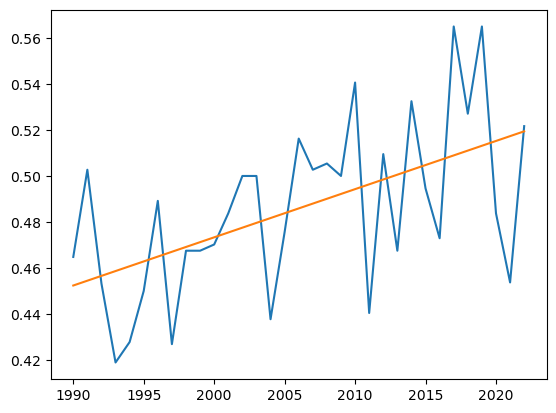

In [78]:
plt.plot(years, acc)
a, b = np.polyfit(years, acc, 1)
plt.plot(years, a * years + b)

In [83]:
# For each year train with data from all other seasons and test games of this year
years2 = np.arange(1980, 2023)
acc2 = []

for year in years2 :

    # Remove data with null features
    data = games.copy()[games['Rest'].notna()]
    # Split data in test and train batches
    train = data.copy()[(data['Season'] !=  year) & (data['Game_home'] > 4) & (data['Game_away'] > 4) & (data['Rest'].abs() < 40)]
    test  = data.copy()[data['Season'] ==   year]
    # Split data as X & y
    X_train, X_test = np.array(train[scraper.features]), np.array(test[scraper.features])
    y_train, y_test = np.array(train[['Win', 'Draw', 'Loss']]), np.array(test[['Win', 'Draw', 'Loss']])

    # Create neural network model
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = len(scraper.features)))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(3,  activation = 'softmax'))

    # Compile model
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.1, verbose = 0)

    preds = model.predict(X_test)
    y_pred = np.zeros_like(preds)
    y_pred[np.arange(len(preds)), preds.argmax(1)] = 1
    accuracy = 1 - np.sign(np.abs(y_test - y_pred).sum(axis = 1))
    acc2.append(accuracy.mean())

12/12 [==============================] - 0s 463us/step


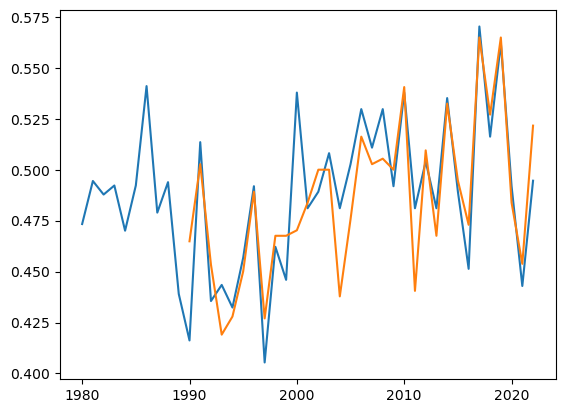

In [86]:
plt.plot(years2, acc2)
plt.plot(years, acc)

In [95]:
# Scrape looped year's schedule
from bs4 import BeautifulSoup
import requests
year = 2022

url = f'https://fbref.com/en/comps/9/{year-1}-{year}/schedule/'
page = requests.get(url)
page.status_code

200

In [ ]:

while soup.find('tr', class_ = 'thead') is not None: # Decompose all headers
    soup.find('tr', class_ = 'thead').decompose()
data = pd.read_html(str(soup.find('table')))[0] # Read table in a dataframe
data = data[data['Home'].notna()] # Remove headers
data = data[['Date', 'Home', 'Away', 'Score']] # Only keep necessary columns
data['Date'] = pd.to_datetime(data['Date']) # Turn dates into datetime format
data['G_home'] = data['Score'].apply(lambda x: int(str(x).split('–')[0])  if (np.all(pd.notnull(x))) else x) # Set home goals
data['G_away'] = data['Score'].apply(lambda x: int(str(x).split('–')[-1]) if (np.all(pd.notnull(x))) else x) # Set away goals

In [163]:
url = f'https://fbref.com/en/comps/0/history/'
page = requests.get(url)
#header = page.text.split('</h1>')[0].split('<h1>')[-1]
#' '.join(header.split('Seasons')[0].split('\t')[-1].split())
soup = BeautifulSoup(page.content, 'lxml')
while soup.find('tr', class_='thead') is not None:
    soup.find('tr', class_='thead').decompose()
table = soup.find('table', id = 'comps_1_fa_club_league_senior')
df = pd.read_html(str(table))[0]
df

,Competition Name,Gender,Country,First Season,Last Season
0,Argentine Primera División,M,ar ARG,2014,2023
1,A-League Men,M,au AUS,2005-2006,2022-2023
2,A-League Women,F,au AUS,2018-2019,2022-2023
3,Austrian Football Bundesliga,M,at AUT,2003-2004,2022-2023
4,ÖFB Frauen-Bundesliga,F,at AUT,2020-2021,2022-2023
...,...,...,...,...,...
59,Ukrainian Premier League,M,ua UKR,2003-2004,2022-2023
60,Uruguayan Primera División,M,uy URU,2014-2015,2023
61,Major League Soccer,M,us USA,1996,2023
62,National Women's Soccer League,F,us USA,2013,2023


In [164]:
df['CODE'] = [int(x['href'].split('/')[3]) for x in list(table.find_all('a', href = True)) if 'comps' in x['href']][0::3]

In [167]:
df = df.groupby('Gender').get_group('M')
df['Country'] = df['Country'].apply(lambda x: x.split()[-1])
df['First Season'] = df['First Season'].apply(lambda x: x[-4:]).astype(int)

In [169]:
df = df.rename(columns = {'Competition Name': 'Competition'})

In [170]:
df

,Competition,Gender,Country,First Season,Last Season,CODE
0,Argentine Primera División,M,ARG,2014,2023,21
1,A-League Men,M,AUS,2006,2022-2023,65
3,Austrian Football Bundesliga,M,AUT,2004,2022-2023,56
5,Belgian First Division A,M,BEL,2004,2022-2023,37
7,División de Fútbol Profesional,M,BOL,2015,2023,74
8,Campeonato Brasileiro Série A,M,BRA,2014,2023,24
10,First Professional Football League,M,BUL,2010,2022-2023,67
11,Canadian Premier League,M,CAN,2019,2023,211
12,Chilean Primera División,M,CHI,2015,2023,35
13,Chinese Football Association Super League,M,CHN,2014,2023,62
